# Variational Autoencoders for galaxy images

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

import torch.nn.functional as F


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert Galaxy10 dataset into Pytorch format

See more information about the data set here: https://astronn.readthedocs.io/en/latest/galaxy10.html

In [3]:
!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2020-12-08 02:58:39--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘Galaxy10.h5.2’

Galaxy10.h5.2       100%[===================>] 200.50M  88.5MB/s    in 2.3s    

2020-12-08 02:58:42 (88.5 MB/s) - ‘Galaxy10.h5.2’ saved [210234548/210234548]



In [4]:
# load entire file into memory
with h5py.File('Galaxy10.h5', 'r') as f:
    print(list(f.keys()))
    images = np.array(f['images'])
    labels = np.array(f['ans'])

images.shape

['ans', 'images']


(21785, 69, 69, 3)

In [5]:
# pre-process
images = (images / 255.).astype(np.float32)

In [6]:
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [7]:
# random split
N = len(images)

np.random.seed(12345)
indices = np.random.permutation(N)
train_idxs = indices[:int(0.8*N)]
valid_idxs = indices[int(0.8*N):]

In [8]:
# transforms and train/valid split
transform = transforms.ToTensor()

train_ds = GalaxyDataset(images[train_idxs], labels[train_idxs], transform)
valid_ds = GalaxyDataset(images[valid_idxs], labels[valid_idxs], transform)

In [9]:
train_loader = DataLoader(
    train_ds,
    batch_size=128,
    num_workers=1,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

valid_loader = DataLoader(
    valid_ds,
    batch_size=128,
    num_workers=1,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

# VAEs

Some of this is based on vanilla VAEs here: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/11-VAE.ipynb

In [10]:
class ConvVAE(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.d = d

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, padding=1),    # 35x35
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 2, padding=1),   # 18x18
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*18*18, 2*d)
        )

        self.dec1 = nn.Sequential(
            nn.Linear(d, 32*18*18),
            nn.Unflatten(1, (32, 18, 18)), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 1, padding=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, 3, 1, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        mu_logvar = self.enc3(x).view(-1, 2, self.d)

        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]

        z = self.reparameterize(mu, logvar)

        x_hat = self.dec1(z)
        x_hat = F.interpolate(x_hat, size=(35, 35), mode='bilinear')

        x_hat = self.dec2(x_hat)
        x_hat = F.interpolate(x_hat, size=(69, 69), mode='bilinear')
        return self.dec3(x_hat), mu, logvar

## Helper functions

In [11]:
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = np.array(in_.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = np.array(out.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

## ELBO as a VAE loss function

In [12]:
model = ConvVAE(d=20).to(device)

In [13]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

def ELBO(x_hat, x, mu, logvar):
    MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


 Epoch 0 | Train: 337.9 | Valid: 85.6


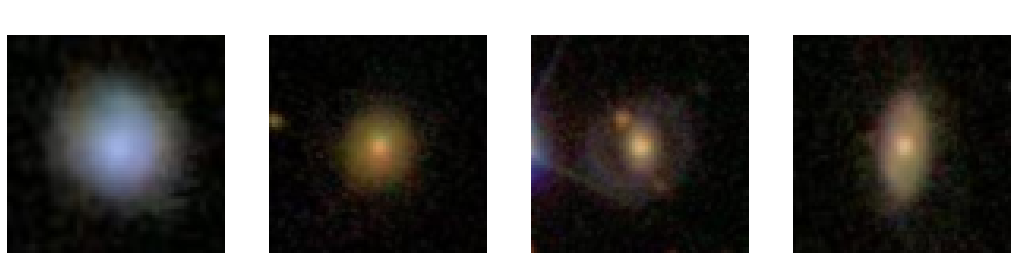

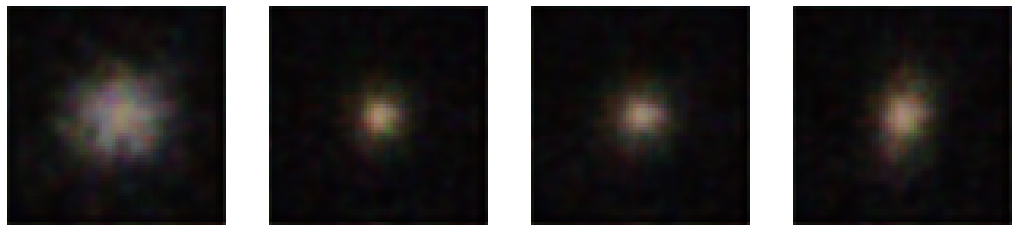

 Epoch 1 | Train: 65.8 | Valid: 49.3
 Epoch 2 | Train: 51.9 | Valid: 54.2
 Epoch 3 | Train: 46.7 | Valid: 40.1
 Epoch 4 | Train: 43.9 | Valid: 40.1
 Epoch 5 | Train: 41.1 | Valid: 35.9
 Epoch 6 | Train: 39.5 | Valid: 31.9
 Epoch 7 | Train: 37.7 | Valid: 40.4
 Epoch 8 | Train: 36.5 | Valid: 32.7
 Epoch 9 | Train: 35.8 | Valid: 33.3
 Epoch 10 | Train: 34.9 | Valid: 33.1


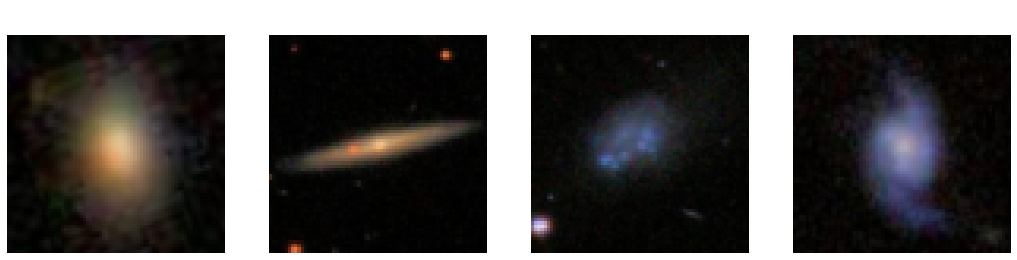

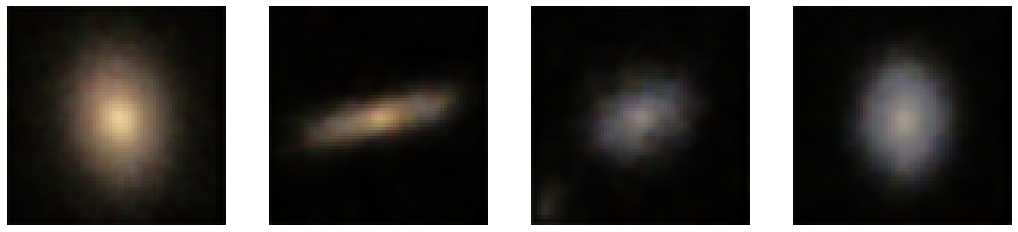

 Epoch 11 | Train: 34.3 | Valid: 28.4
 Epoch 12 | Train: 33.6 | Valid: 28.1
 Epoch 13 | Train: 32.8 | Valid: 27.6
 Epoch 14 | Train: 32.4 | Valid: 28.3
 Epoch 15 | Train: 32.3 | Valid: 27.5
 Epoch 16 | Train: 31.6 | Valid: 28.2
 Epoch 17 | Train: 31.3 | Valid: 27.2
 Epoch 18 | Train: 30.9 | Valid: 27.5
 Epoch 19 | Train: 30.7 | Valid: 27.1
 Epoch 20 | Train: 30.5 | Valid: 30.2


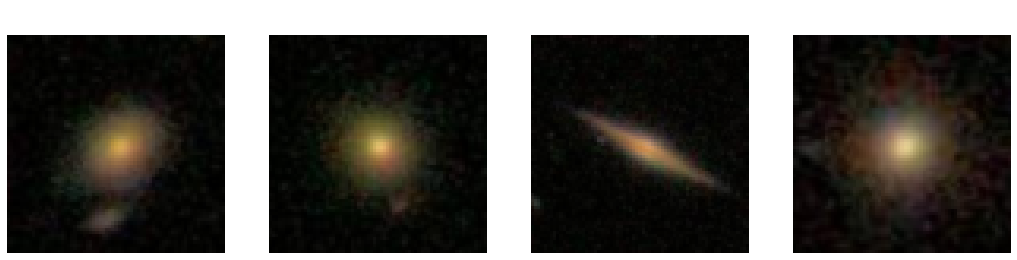

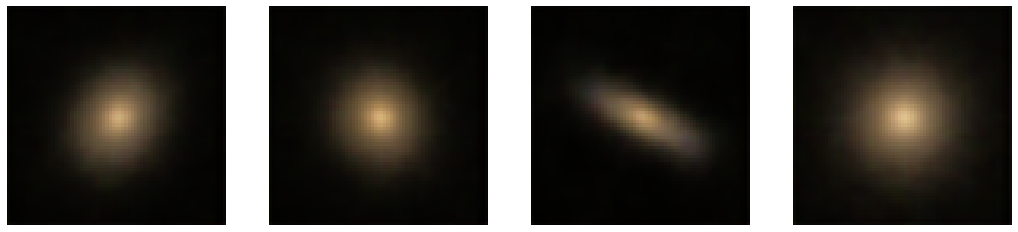

 Epoch 21 | Train: 30.5 | Valid: 26.2
 Epoch 22 | Train: 30.1 | Valid: 27.2
 Epoch 23 | Train: 29.8 | Valid: 27.4
 Epoch 24 | Train: 29.5 | Valid: 26.0
 Epoch 25 | Train: 29.3 | Valid: 27.3
 Epoch 26 | Train: 29.4 | Valid: 25.7
 Epoch 27 | Train: 29.2 | Valid: 26.4
 Epoch 28 | Train: 29.0 | Valid: 26.7
 Epoch 29 | Train: 28.8 | Valid: 25.9
 Epoch 30 | Train: 28.7 | Valid: 26.1


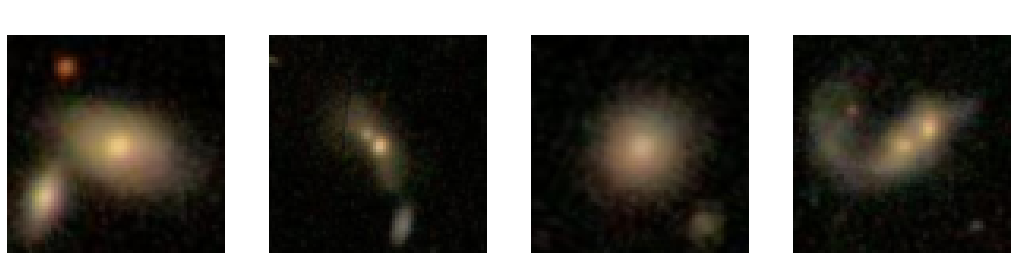

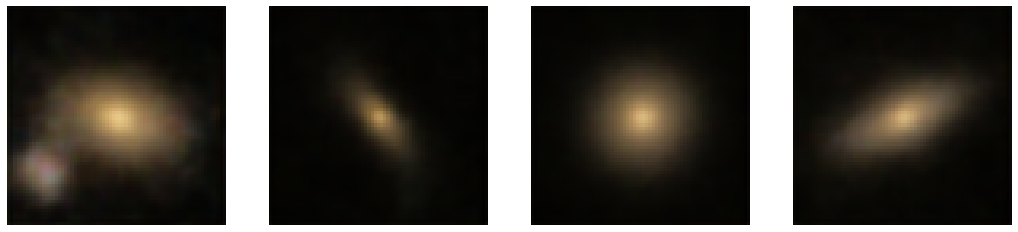

 Epoch 31 | Train: 28.7 | Valid: 25.4
 Epoch 32 | Train: 28.7 | Valid: 27.0
 Epoch 33 | Train: 28.5 | Valid: 26.0
 Epoch 34 | Train: 28.4 | Valid: 25.5
 Epoch 35 | Train: 28.3 | Valid: 27.0
 Epoch 36 | Train: 28.5 | Valid: 26.1
 Epoch 37 | Train: 28.2 | Valid: 25.6
 Epoch 38 | Train: 28.2 | Valid: 25.4
 Epoch 39 | Train: 28.0 | Valid: 25.5
 Epoch 40 | Train: 28.0 | Valid: 25.4


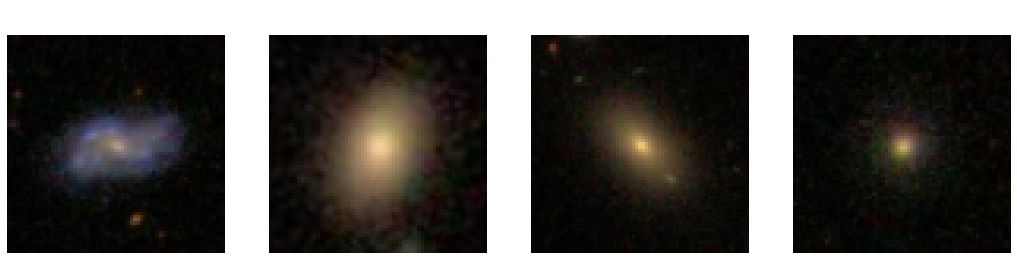

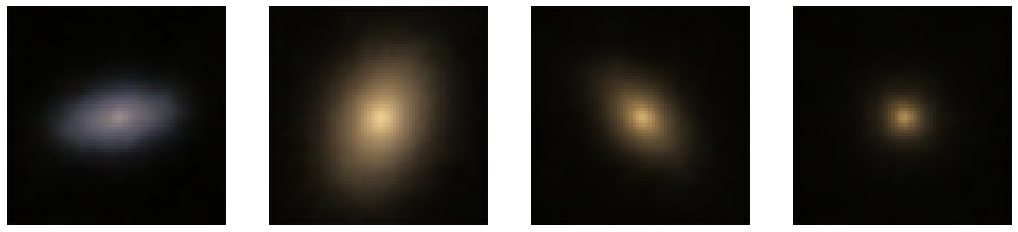

 Epoch 41 | Train: 27.9 | Valid: 25.7
 Epoch 42 | Train: 27.9 | Valid: 25.3
 Epoch 43 | Train: 27.9 | Valid: 25.4
 Epoch 44 | Train: 28.1 | Valid: 25.0
 Epoch 45 | Train: 27.9 | Valid: 24.8
 Epoch 46 | Train: 27.8 | Valid: 24.6
 Epoch 47 | Train: 27.6 | Valid: 24.9
 Epoch 48 | Train: 27.6 | Valid: 24.7
 Epoch 49 | Train: 27.6 | Valid: 25.7
 Epoch 50 | Train: 27.6 | Valid: 25.0


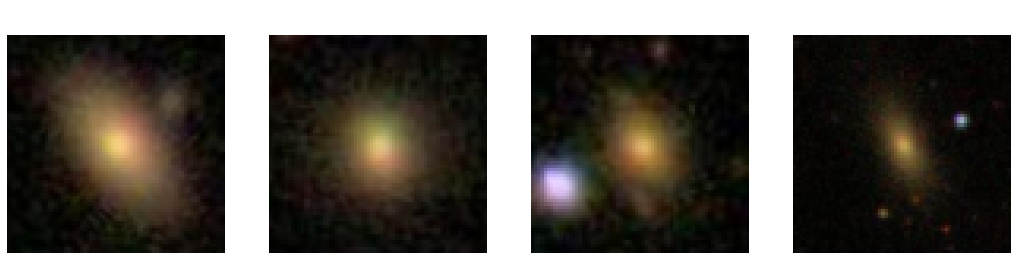

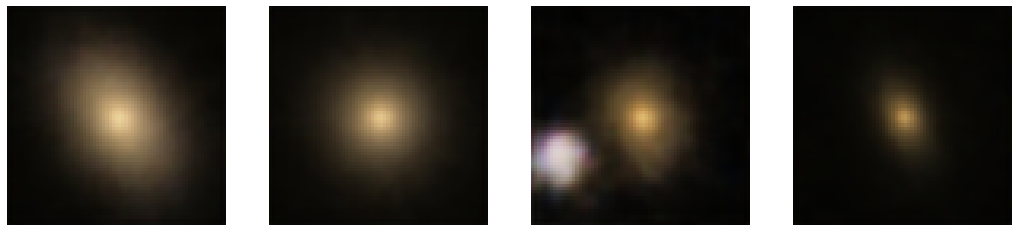

In [14]:
validation_losses = []

for epoch in range(0, 51):
    # train
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss = ELBO(x_hat, x, mu, logvar)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    # validate
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for x, y in valid_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            valid_loss += ELBO(x_hat, x, mu, logvar)
            
    validation_losses.append(valid_loss / len(valid_loader.dataset))
    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.1f} | Valid: {validation_losses[-1]:.1f}')

    # display
    if epoch % 10 == 0:
        display_images(x, x_hat, 1, f'Epoch {epoch}')
        plt.show()

## MMD + ELBO loss function (InfoVAE)
See, e.g., https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/

In [22]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)
    y = y.unsqueeze(0) 
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) 
    return torch.exp(-kernel_input) # (x_size, y_size)
    
def compute_mmd(x, y):
    xx_kernel = compute_kernel(x,x)
    yy_kernel = compute_kernel(y,y)
    xy_kernel = compute_kernel(x,y)
    return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)

def MMD_loss(model, x_hat, x, mu, logvar, alpha=1.0, beta=1.0):
    
    MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
    true_samples = torch.autograd.Variable(
        torch.randn(200, model.d), 
        requires_grad=False
    ).to(device)
    z = model.reparameterize(mu, logvar) 
    MMD = compute_mmd(true_samples, z) * x.size(0) * model.d

    return MSE + (1 - alpha)*KLD + (beta + alpha-1)*MMD

In [23]:
model = ConvVAE(d=50).to(device)

In [24]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


 Epoch 0 | Train: 305.0 | Valid: 52.6


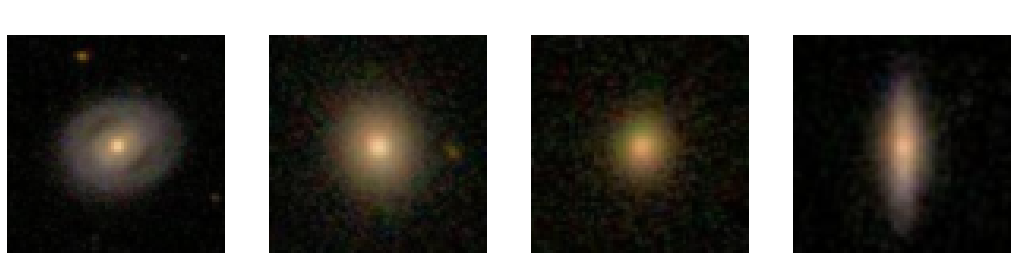

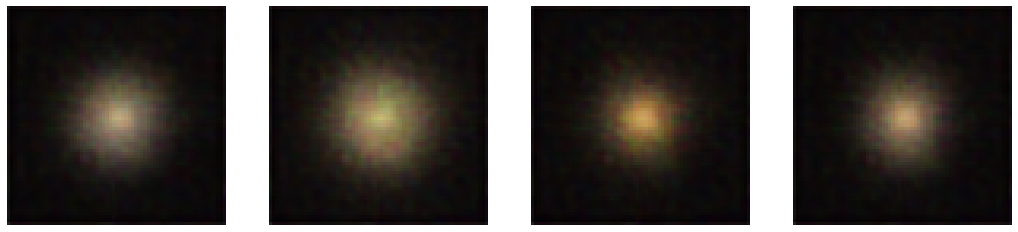

 Epoch 1 | Train: 38.9 | Valid: 31.3
 Epoch 2 | Train: 29.4 | Valid: 26.3
 Epoch 3 | Train: 25.6 | Valid: 24.8
 Epoch 4 | Train: 23.5 | Valid: 23.2
 Epoch 5 | Train: 22.1 | Valid: 21.8
 Epoch 6 | Train: 21.6 | Valid: 21.1
 Epoch 7 | Train: 20.7 | Valid: 20.4
 Epoch 8 | Train: 20.0 | Valid: 19.8
 Epoch 9 | Train: 19.7 | Valid: 20.9
 Epoch 10 | Train: 19.5 | Valid: 19.7


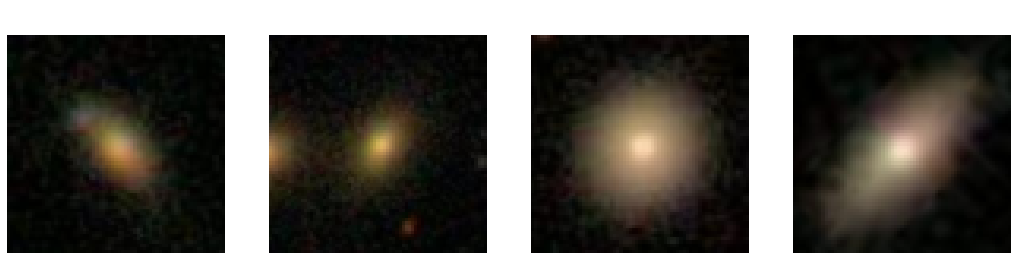

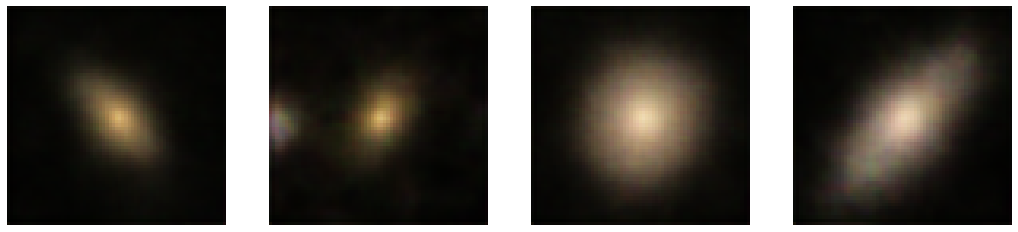

 Epoch 11 | Train: 19.2 | Valid: 20.2
 Epoch 12 | Train: 19.0 | Valid: 20.4
 Epoch 13 | Train: 18.8 | Valid: 20.1
 Epoch 14 | Train: 18.6 | Valid: 18.8
 Epoch 15 | Train: 18.4 | Valid: 19.8
 Epoch 16 | Train: 18.2 | Valid: 18.7
 Epoch 17 | Train: 18.1 | Valid: 18.7
 Epoch 18 | Train: 18.3 | Valid: 18.5
 Epoch 19 | Train: 17.9 | Valid: 19.2
 Epoch 20 | Train: 18.0 | Valid: 18.2


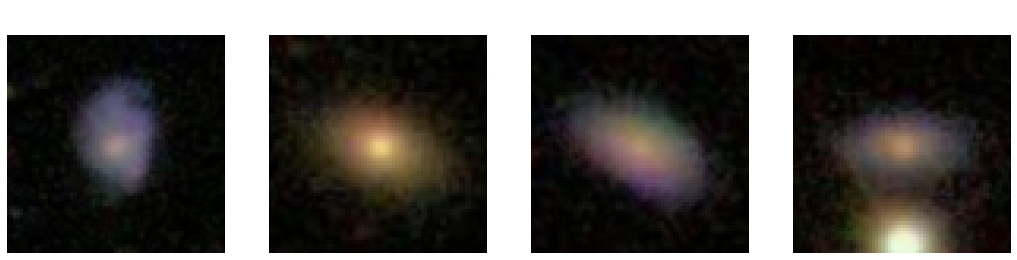

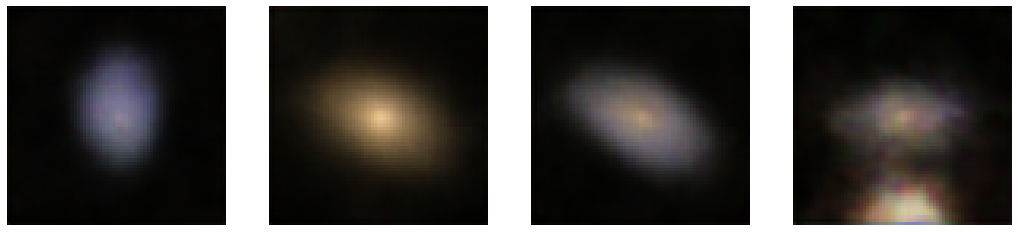

 Epoch 21 | Train: 17.7 | Valid: 18.3
 Epoch 22 | Train: 17.8 | Valid: 18.4
 Epoch 23 | Train: 17.7 | Valid: 17.9
 Epoch 24 | Train: 17.4 | Valid: 17.8
 Epoch 25 | Train: 17.2 | Valid: 17.9
 Epoch 26 | Train: 17.2 | Valid: 18.0
 Epoch 27 | Train: 17.3 | Valid: 18.3
 Epoch 28 | Train: 17.1 | Valid: 18.2
 Epoch 29 | Train: 17.2 | Valid: 18.1
 Epoch 30 | Train: 17.2 | Valid: 17.9


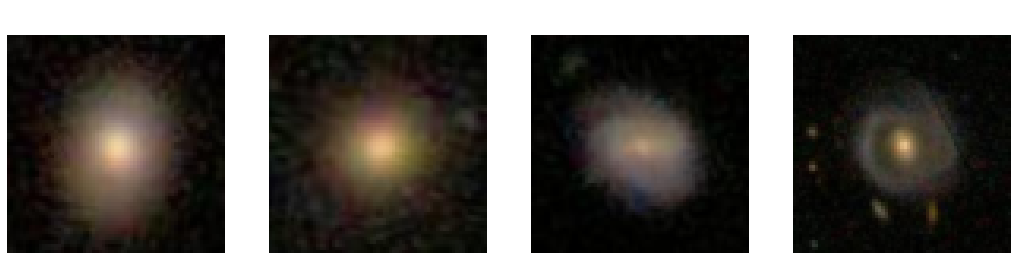

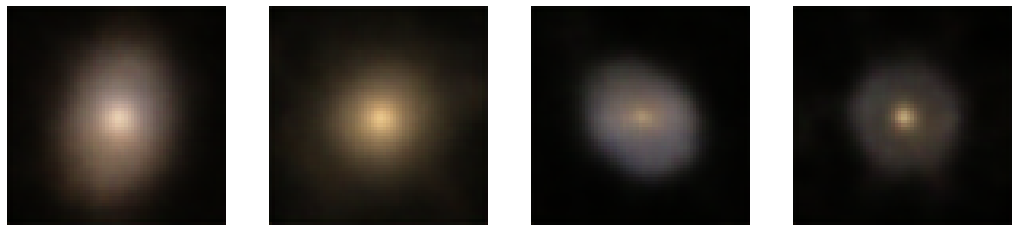

 Epoch 31 | Train: 17.2 | Valid: 18.2
 Epoch 32 | Train: 16.9 | Valid: 18.0
 Epoch 33 | Train: 16.9 | Valid: 17.8
 Epoch 34 | Train: 17.0 | Valid: 17.7
 Epoch 35 | Train: 16.7 | Valid: 17.3
 Epoch 36 | Train: 16.7 | Valid: 17.3
 Epoch 37 | Train: 16.7 | Valid: 18.4
 Epoch 38 | Train: 16.5 | Valid: 17.2
 Epoch 39 | Train: 16.5 | Valid: 17.5
 Epoch 40 | Train: 16.5 | Valid: 17.9


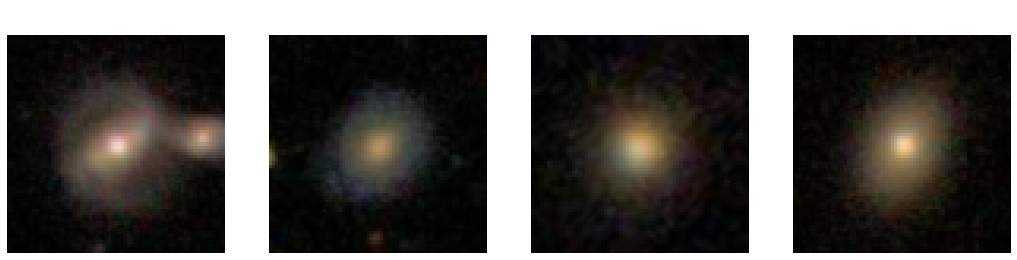

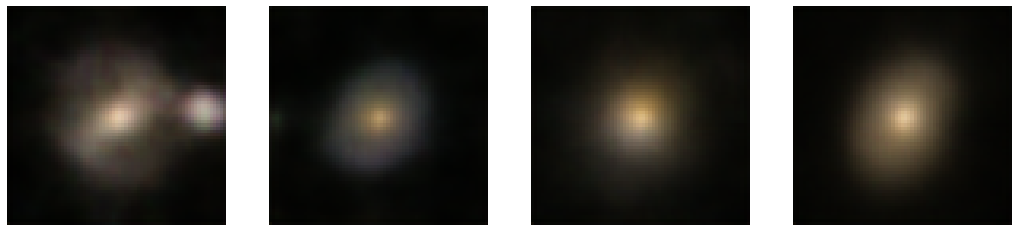

 Epoch 41 | Train: 16.6 | Valid: 17.6
 Epoch 42 | Train: 16.4 | Valid: 18.1
 Epoch 43 | Train: 16.3 | Valid: 17.1
 Epoch 44 | Train: 16.2 | Valid: 17.9
 Epoch 45 | Train: 16.2 | Valid: 17.1
 Epoch 46 | Train: 16.2 | Valid: 17.5
 Epoch 47 | Train: 16.1 | Valid: 17.2
 Epoch 48 | Train: 16.3 | Valid: 18.3
 Epoch 49 | Train: 19.9 | Valid: 17.5
 Epoch 50 | Train: 16.9 | Valid: 17.5


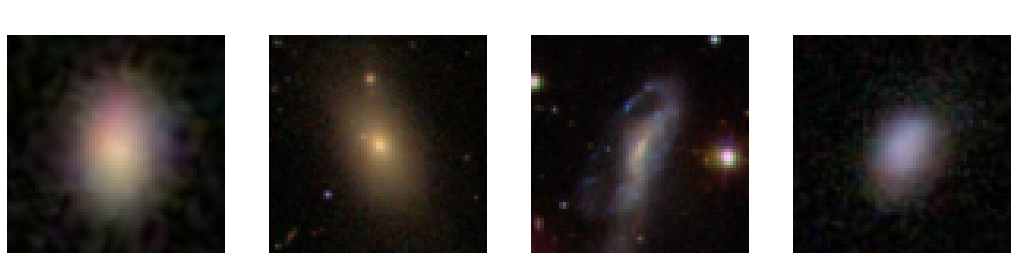

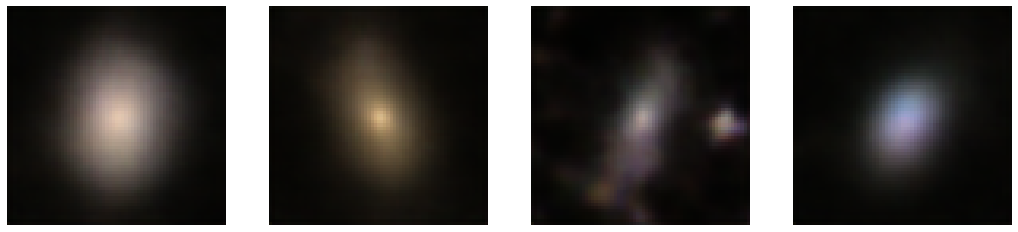

In [25]:
MMD_validation_losses = []

for epoch in range(0, 51):
    # train
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss = MMD_loss(model, x_hat, x, mu, logvar)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # validate
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for x, y in valid_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            valid_loss += MMD_loss(model, x_hat, x, mu, logvar)
            
    MMD_validation_losses.append(valid_loss / len(valid_loader.dataset))
    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.1f} | Valid: {MMD_validation_losses[-1]:.1f}')

    # display
    if epoch % 10 == 0:
        display_images(x, x_hat, 1, f'Epoch {epoch}')
        plt.show()